# Info 

Author: Xiaoqian Sun <br>
Created: 08/2023 <br>
Function: Simulate a neuron firing video using Poisson-based-spike-generation method, input into CaImAn and check whether the inferred spikes are accurate. <br>
Steps in this code:
- create simulation parameter object `simuParams(params_dict=opts_dict)`
- simulation neuron activities `Simulation(params=simuPara)`
    - now, neuron activity is like noisy calcium trace 
- attach generated neuron activit to neurons in a ROI and generate TIF
    - so that TIF can be used as input to CaImAn


In [10]:
import os 
import cv2
import time
import h5py
import random
import pickle
import imageio
import rasterio
import numpy as np
import pandas as pd
from tifffile import imsave
from rasterio.plot import show
import matplotlib.pyplot as plt
from scipy.sparse import issparse, spdiags, coo_matrix, csc_matrix

from Functions import *
from simuParams import simuParams
from simulation import Simulation
from peelParams import peelParams
from peelReconstruction import peelReconstr

import warnings
warnings.filterwarnings('ignore')

In [11]:
# file path
root_path = os.getcwd()
data_path = os.path.join(root_path, 'Poisson_CaImAnTest')

# parameters
dur = 10
cellNum = 10
frameRate = 30
dims = (512, 512)

# A1 = np.array([8]*cellNum)
A1 = np.array([8, 8.5, 9, 8, 8.5, 9, 8, 8.5, 9, 8])
# A1 = np.array([8, 8.1, 8.2, 8.3, 8.4, 8.5, 8, 8.1, 8.2, 8.3])
spikeRate = np.array([0.6, 0.8, 1.0, 0.2, 0.4, 1.0, 1.2, 1.4, 1.6, 2])
snr = np.array([4, 5, 6, 3, 4, 5, 4, 5, 6, 3])

# Simulation

In [12]:
# simulation parameter obj
#-----------------------------------------------------------------
opts_dict = {'doVectorized': True,
             'cellNum': cellNum,
             'dur': dur,
             'samplingRate': 600, 
             
             'A1':A1,
             'A2': np.array([0]*cellNum),
             'tau1': np.array([0.5]*cellNum),
             'tau2': np.array([1]*cellNum),
             'tauOn': np.array([0.01]*cellNum),
             
             'spikeRate': spikeRate,
             'snr': snr,
             
             'ca_amp': np.array([7100]*cellNum),
            }

simuPara = simuParams(params_dict=opts_dict)
print(simuPara.get('simulation', 'snr'))
print(simuPara.get('simulation', 'noiseSD'))
print(simuPara.get('simulation', 'spkTimes'))
print(simuPara.get('simulation', 'kappab'))
print()



# build Simulation Object
#-----------------------------------------------------------------
simuObj = Simulation(params=simuPara)

print(simuObj.cellNum, 'neurons in total')
print('fluorescence has', len(simuObj.x), 'time points')
print('gaussian noise sds:', simuObj.params.simulation['noiseSD'])
print('dff has', len(simuObj.xSampled), 'time points')
print('2nd neuron has', len(simuObj.spkTimes[1]), 'spikes')
print('final dff has shape:', simuObj.dff.shape)
print()


# save
#-----------------------------------------------------------------
with open(os.path.join(data_path,'simulation_Object.pkl'), 'wb') as fp:
    pickle.dump(simuObj, fp)
    print('simuObj  saved')
print()    
    
    
    
# plot trace
#-----------------------------------------------------------------
# simuObj.plot_allTraces(ifSave=False)
dff = simuObj.dff
simuObj.plot_allTraces(ifSave=True, savePath=data_path, filename='simulation_DFF.png')

noisyFluor = simuObj.noisyFluor
noisyFluor_DFF = pd.DataFrame(noisyFluor).T
plot_neuronTrace_DFs([noisyFluor_DFF],['noisyFluor'],['b'],[1],[1],
                     ifSave=True,savePath=data_path,filename='simulation_F' )


# check spikes
for i in range(cellNum):
    print((i+1), 'neuron has', len(simuObj.spkTimes[i]), 'spikes')
print() 

print('Done.')

[4 5 6 3 4 5 4 5 6 3]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[[], [], [], [], [], [], [], [], [], []]
138.88888888888889

10 neurons in total
fluorescence has 6000 time points
gaussian noise sds: [1.81250169 1.54062644 1.35937627 2.41666892 1.92578305 1.63125152
 1.81250169 1.54062644 1.35937627 2.41666892]
dff has 300 time points
2nd neuron has 8 spikes
final dff has shape: (10, 300)

simuObj  saved

Done.


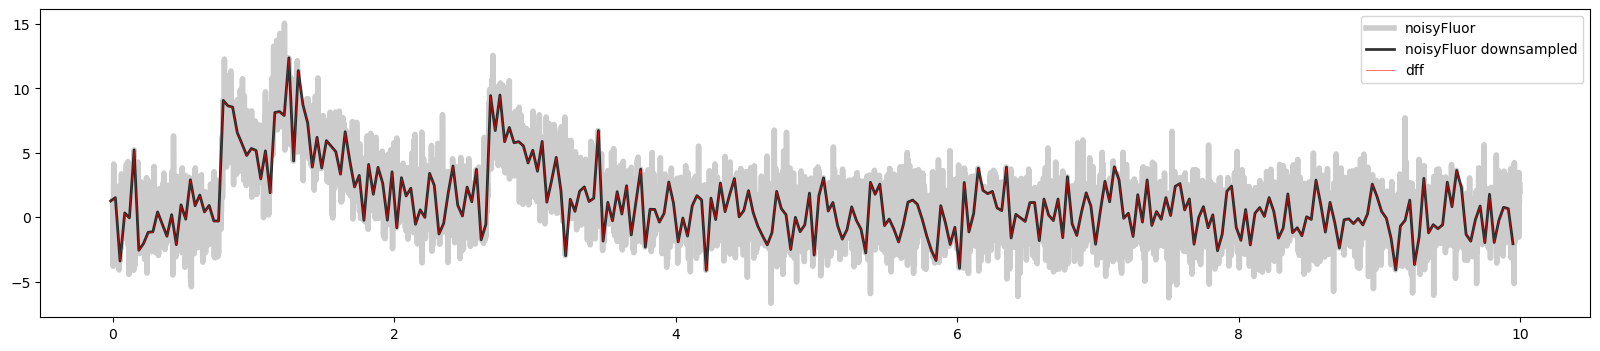

In [27]:
# a certain trace
nIndex = 0

plt.figure(figsize=(20, 4))
plt.plot(simuObj.x, simuObj.noisyFluor[nIndex, :], c='black', alpha=0.2, lw=4, label='noisyFluor')
plt.plot(simuObj.xSampled, simuObj.sampledFluor[nIndex, :], c='black', alpha=0.8, lw=2, label='noisyFluor downsampled')
plt.plot(simuObj.xSampled, simuObj.dff[nIndex, :], c='red', lw=0.4, label='dff')

plt.legend(loc=0)
plt.show()

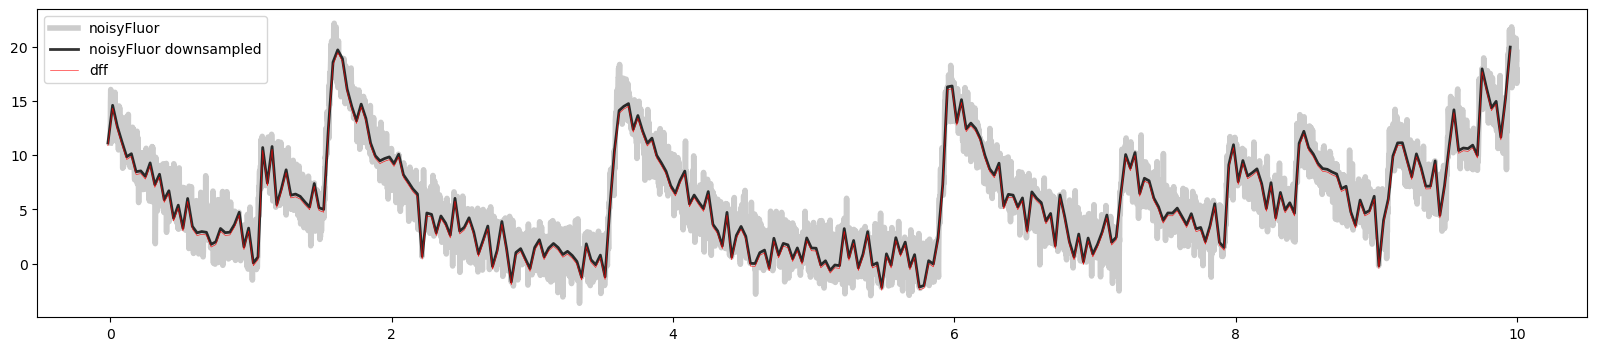

In [26]:
# a certain trace
nIndex = 8

plt.figure(figsize=(20, 4))
plt.plot(simuObj.x, simuObj.noisyFluor[nIndex, :], c='black', alpha=0.2, lw=4, label='noisyFluor')
plt.plot(simuObj.xSampled, simuObj.sampledFluor[nIndex, :], c='black', alpha=0.8, lw=2, label='noisyFluor downsampled')
plt.plot(simuObj.xSampled, simuObj.dff[nIndex, :], c='red', lw=0.4, label='dff')

plt.legend(loc=0)
plt.show()

# Generate TIF Based on Simulated Spikes 

In [13]:
print(noisyFluor.shape)
numFrames = noisyFluor.shape[1]

(10, 6000)


### Read in a previous hdf5 file, use neuron shape

Done loading CaImAn result file. Imgs with shape [512 512] . And template loaded.
Select Neurons are: [20, 32, 24, 31, 14, 19, 34, 12, 29, 11]
spatial compoennets for simulation A_F = (262144, 10) E.g., [0 0 0 ... 0 0 0]
unique values are: [array([  0, 255]), array([  0, 255]), array([  0, 255]), array([  0, 255]), array([  0, 255]), array([  0, 255]), array([  0, 255]), array([  0, 255]), array([  0, 255]), array([  0, 255])]
unique values counts are: [array([262098,     46]), array([262100,     44]), array([262089,     55]), array([262090,     54]), array([262095,     49]), array([262084,     60]), array([262098,     46]), array([262096,     48]), array([262087,     57]), array([262101,     43])]


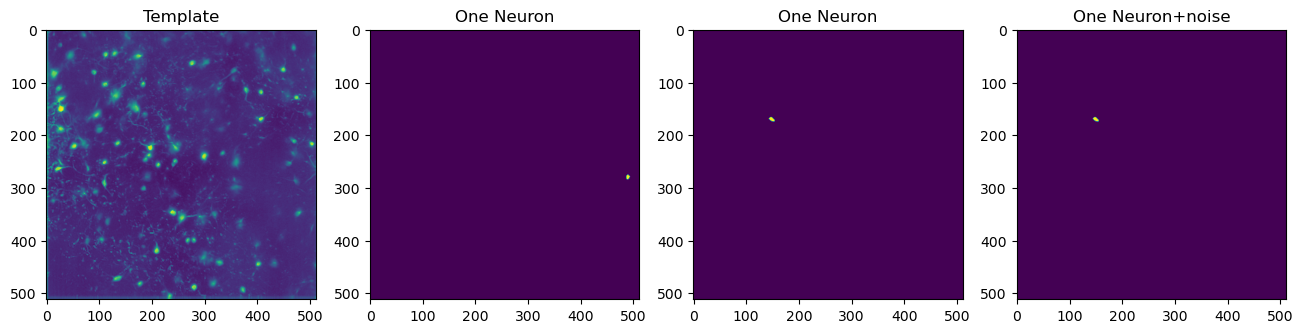

In [14]:
# Read in 
#-----------------------------------------------------------------
baseName = 'VN004-M-WT-Day01-2p_Ch1_Z1'

cnm2_object = h5py.File(os.path.join(data_path, baseName+'.hdf5'), 'r')
dims = cnm2_object['dims'][:]
template = np.load(os.path.join(data_path, baseName+'_localCorrImg.npy')) 
print('Done loading CaImAn result file. Imgs with shape', dims, '. And template loaded.')



# neuron coordinates
#-----------------------------------------------------------------
coor = pd.read_csv(os.path.join(data_path, baseName+"-CC.csv")).iloc[: , 1:4]
final_acceptedNeurons = coor['neuronIndex'].values.tolist()
# randomNeurons = random.sample(range(1,len(final_acceptedNeurons)), cellNum)
randomNeurons = [20, 32, 24, 31, 14, 19, 34, 12, 29, 11]
coor.iloc[randomNeurons].to_csv(os.path.join(data_path, 'pickedNeurons.csv'))
print('Select Neurons are:', randomNeurons)



# spatial components
#-----------------------------------------------------------------
A = csc_matrix((cnm2_object['estimates']['A']['data'][:], 
                cnm2_object['estimates']['A']['indices'][:], 
                cnm2_object['estimates']['A']['indptr'][:]), 
               shape=cnm2_object['estimates']['A']['shape'][:]).toarray()
A = A[:,final_acceptedNeurons] 
# apply threshold, remove background noise
A_simThresh, vs, cs = filterNeuron_cv2Thresh(A, randomNeurons, lowerThres=20)
# plot select neurons
plot_selectNeuronShape(A_simThresh,randomNeurons,rows=2,cols=5,figsize=(20, 10),
                       ifSave=True,savePath=data_path,filename='selectNeusonShape')
print('spatial compoennets for simulation A_F =', A_simThresh.shape, 'E.g.,', A_simThresh[:,5])
print('unique values are:', vs)
print('unique values counts are:', cs)
b = cnm2_object['estimates']['b'][:] # background noise spacial component
A_simThresh_b = A_simThresh
# add backgroun noise to each neuron
for i in range(cellNum):
    A_simThresh_b[:, i] = A_simThresh[:, i] + b[:, 0] + b[:, 1]



# show template & 1 neuron
#-----------------------------------------------------------------
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16,6))
ax1.set_title('Template')
ax1.imshow(template)

ax2.set_title('One Neuron')
ax2.imshow((A_simThresh[:, 0]).reshape(512, 512))

ax3.set_title('One Neuron')
ax3.imshow((A_simThresh[:,5]).reshape(512, 512))

ax4.set_title('One Neuron+noise')
ax4.imshow((A_simThresh_b[:, 5]).reshape(512, 512))

plt.show()

### Reconstruct Movie - F, wihtout background noise

In [15]:
# reconstruct movie
#-----------------------------------------------------------------
currentTime = time.time()
mv_rec = np.dot(A_simThresh, noisyFluor).reshape((dims[0],dims[1],numFrames)).transpose((2,0,1))    

print('movie array shape:', mv_rec.shape)
print('calculation costs', round(time.time()-currentTime, 3), 'seconds')



# save
#-----------------------------------------------------------------
currentTime = time.time()
with open(os.path.join(data_path,'simulation_movie_ndarray.pkl'), 'wb') as fp:
    pickle.dump(mv_rec, fp)
    print('mv_rec saved. Saving costs', round(time.time()-currentTime, 3), 'seconds')

    
# save to tif
currentTime = time.time()
imsave(os.path.join(data_path,'simulation_movie.tif'), mv_rec)
print('mv_rec saved to tif')
# save image array to gif
mv_rec_uint8 = np.uint8(mv_rec)
with imageio.get_writer(os.path.join(data_path,'simulation_movie.gif'), mode='I') as writer:
    for i in range(len(mv_rec_uint8)):
        writer.append_data(mv_rec_uint8[i, :, :])
print('Movie GIF Saved. Saving costs', round(time.time()-currentTime, 3), 'seconds')   
 

movie array shape: (6000, 512, 512)
calculation costs 28.689 seconds
mv_rec saved. Saving costs 79.084 seconds
mv_rec saved to tif
Movie GIF Saved. Saving costs 205.353 seconds


### Reconstruct Movie - F, with background noise

### Reconstruct Movie - DFF, without background noise